In [1]:
!pip install -q transformers datasets torch scikit-learn pandas tqdm matplotlib seaborn


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("Reviews.csv")
df = df[['Text', 'Score']].dropna()
print("Dataset size:", len(df))
print(df.head())


Dataset size: 568454
                                                Text  Score
0  I have bought several of the Vitality canned d...      5
1  Product arrived labeled as Jumbo Salted Peanut...      1
2  This is a confection that has been around a fe...      4
3  If you are looking for the secret ingredient i...      2
4  Great taffy at a great price.  There was a wid...      5


In [4]:
def label_sentiment(score):
    if score <= 2:
        return 0  # Negative
    elif score == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

In [5]:
df['label'] = df['Score'].apply(label_sentiment)
df = df[['Text', 'label']]

/tmp/ipython-input-4129563293.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label'], palette='Set2')


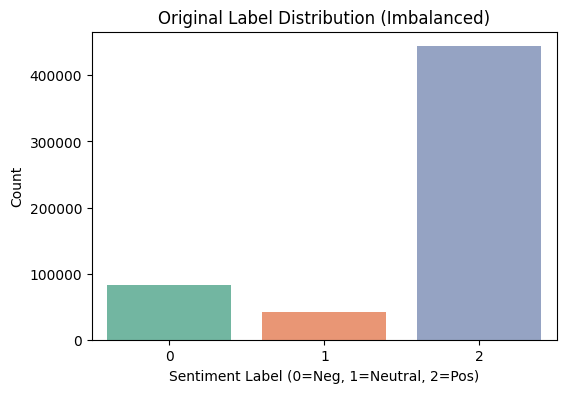

In [6]:
plt.figure(figsize=(6,4))
sns.countplot(x=df['label'], palette='Set2')
plt.title("Original Label Distribution (Imbalanced)")
plt.xlabel("Sentiment Label (0=Neg, 1=Neutral, 2=Pos)")
plt.ylabel("Count")
plt.show()

In [7]:
print("\nLabel distribution before balancing:\n", df['label'].value_counts())


Label distribution before balancing:
 label
2    443777
0     82037
1     42640
Name: count, dtype: int64


In [8]:
min_size = df['label'].value_counts().min()
balanced_df = (
    df.groupby('label', group_keys=False)
      .apply(lambda x: x.sample(min_size, random_state=42))
      .reset_index(drop=True)
)

/tmp/ipython-input-1844073355.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min_size, random_state=42))


/tmp/ipython-input-2076373038.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=balanced_df['label'], palette='Set1')


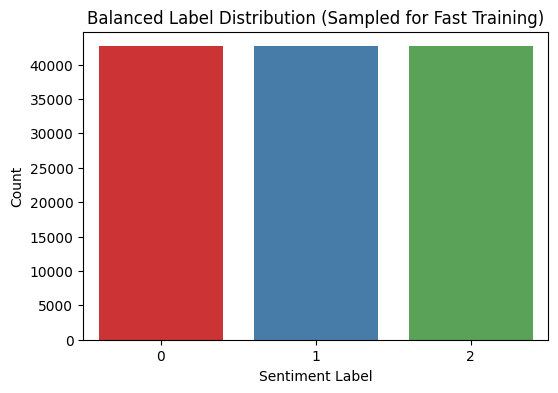


Balanced label distribution:
 label
0    42640
1    42640
2    42640
Name: count, dtype: int64


In [9]:
plt.figure(figsize=(6,4))
sns.countplot(x=balanced_df['label'], palette='Set1')
plt.title("Balanced Label Distribution (Sampled for Fast Training)")
plt.xlabel("Sentiment Label")
plt.ylabel("Count")
plt.show()

print("\nBalanced label distribution:\n", balanced_df['label'].value_counts())

In [10]:
train_df, test_df = train_test_split(balanced_df, test_size=0.1, random_state=42)


In [11]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize(batch):
    return tokenizer(batch['Text'], padding='max_length', truncation=True, max_length=64)

train_dataset = Dataset.from_pandas(train_df).map(tokenize, batched=True)
test_dataset = Dataset.from_pandas(test_df).map(tokenize, batched=True)

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/115128 [00:00<?, ? examples/s]

Map:   0%|          | 0/12792 [00:00<?, ? examples/s]

In [12]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    logging_dir='./logs',
    logging_steps=100,
    save_total_limit=2,

)

In [14]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}


In [15]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [16]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ankitk24 (ankitk24-indian-institute-of-science-education-and-resea) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
100,0.915100
200,0.814200
300,0.795100
400,0.727200
500,0.729200
600,0.728900
700,0.722500
800,0.712300
900,0.705600
1000,0.677200


TrainOutput(global_step=7196, training_loss=0.6161584202086283, metrics={'train_runtime': 972.2184, 'train_samples_per_second': 118.418, 'train_steps_per_second': 7.402, 'total_flos': 1906372330896384.0, 'train_loss': 0.6161584202086283, 'epoch': 1.0})

In [17]:
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids


In [18]:
acc = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive'])
print(f"\n✅ Accuracy: {acc*100:.2f}%\n")
print("Classification Report:\n", report)



✅ Accuracy: 78.04%

Classification Report:
               precision    recall  f1-score   support

    Negative       0.78      0.80      0.79      4368
     Neutral       0.72      0.70      0.71      4273
    Positive       0.84      0.84      0.84      4151

    accuracy                           0.78     12792
   macro avg       0.78      0.78      0.78     12792
weighted avg       0.78      0.78      0.78     12792



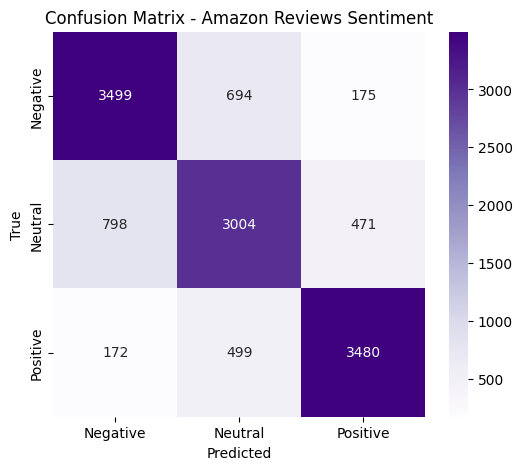

In [19]:
cm = confusion_matrix(y_true, y_pred)
labels = ['Negative', 'Neutral', 'Positive']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Amazon Reviews Sentiment')
plt.show()


/tmp/ipython-input-3704505552.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics_dict.keys()), y=list(metrics_dict.values()), palette="cool")


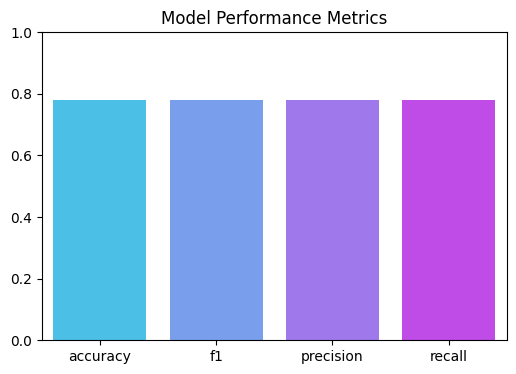

In [20]:
metrics_dict = compute_metrics(predictions)
plt.figure(figsize=(6,4))
sns.barplot(x=list(metrics_dict.keys()), y=list(metrics_dict.values()), palette="cool")
plt.title("Model Performance Metrics")
plt.ylim(0,1)
plt.show()

In [22]:
def predict_sentiment(text):
    model.eval()  # set model to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}  # move all inputs to same device

    with torch.no_grad():
        outputs = model(**inputs)
        pred = torch.argmax(outputs.logits, dim=1).item()

    labels = ['Negative', 'Neutral', 'Positive']
    return labels[pred]
print("\n--- Example Predictions ---")
print("Text: This product is amazing! →", predict_sentiment("This product is amazing!"))
print("Text: Terrible quality, broke after one use. →", predict_sentiment("Terrible quality, broke after one use."))
print("Text: It’s okay, not great but not bad either. →", predict_sentiment("It’s okay, not great but not bad either."))



--- Example Predictions ---
Text: This product is amazing! → Positive
Text: Terrible quality, broke after one use. → Negative
Text: It’s okay, not great but not bad either. → Neutral


In [23]:
model.save_pretrained("./distilbert_amazon_model")
tokenizer.save_pretrained("./distilbert_amazon_tokenizer")

print("\n✅ Model and tokenizer saved successfully!")


✅ Model and tokenizer saved successfully!
